construct dataset

In [1]:
from datasets import load_dataset

ds = load_dataset("JeanKaddour/minipile")

In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import pandas as pd
from datetime import datetime

# Initialize an empty DataFrame
df_all_sentences = pd.DataFrame(columns=['sentence'])

row_index = 0
for text in ds['train']['text'][:10000]:
    sentences = sent_tokenize(text)
    for sentence in sentences:
        # Use .at to set the value in the DataFrame
        df_all_sentences.at[row_index, 'sentence'] = sentence
        row_index += 1

    if row_index % 100 == 0:
        print(row_index)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'files/all_sentences_{timestamp}.csv'
df_all_sentences.to_csv(filename, index=False)


[nltk_data] Downloading package punkt to /sailhome/joetey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2900
5100
8300
14400
14600
15100
22900
25200
25600
29200
34600
35500
36000
36200
38900
41600
51400
53800
55500
57900
58600
59600
61700
69600
71700
73200
74400
77200
79300
82000
83100
86200
92500
93400
96000
99100
99500
106200
109400
113600
115900
121300
126400
135500
143600
145100
145200
146400
156900
158200
158600
158900
164700
175200
176700
190500
192900
195000
197500
197800
198300
202200
203400
213700
216400
218400
220200
221100
223800
224400
227100
228800
238600
244700
247000
253000
253200
258700
263300
268500
270700
277100
283900
287600
288500
289600
298400
309600
311200
316500
319600
319800
322400
323800
324000
338900
343400
345600
346500
348800
354400
354900
357600
359800
365100
369200
369900
374300
374400
375900
376800
381100
389700


In [6]:
from torch.utils.data import Dataset

class MiniPileDataset(Dataset):
    def __init__(self, sentences, embeddings):
        self.sentences = sentences
        self.embeddings = embeddings

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.embeddings[idx]

In [12]:
from transformers import AutoTokenizer, AutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

In [ ]:
# Write the dataset to a CSV file
import csv
from datetime import datetime
import torch

embeddings = []
sentences_passed = []

batch_size = 10
sentences = df_all_sentences['sentence'].tolist()

for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i + batch_size]
    try:
        inputs = bert_tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).detach()
        embeddings.extend(batch_embeddings)
        sentences_passed.extend(batch)
        
    except Exception as e:
        print(f"Error: {e}")
        continue
        
    print(f"Processed {i + len(batch)} sentences")

embeddings = torch.stack(embeddings)

# Initialize the dataset
mini_pile_dataset = MiniPileDataset(sentences, embeddings)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'files/all_sentences_with_embeddings_{timestamp}.pkl'
# with open(filename, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['sentence', 'embedding'])
#     for sentence, embedding in zip(mini_pile_dataset.sentences, mini_pile_dataset.embeddings):
#         writer.writerow([sentence, embedding])

import pickle

# Save the model to a pickle file
with open(filename, "wb") as f:
    pickle.dump(mini_pile_dataset, f)

print(f"Embeddings saved to {filename}")


Processed 10 sentences
Processed 20 sentences
Processed 30 sentences
Processed 40 sentences
Processed 50 sentences
Processed 60 sentences
Processed 70 sentences
Processed 80 sentences
Processed 90 sentences
Processed 100 sentences
Processed 110 sentences
Processed 120 sentences
Processed 130 sentences
Processed 140 sentences
Processed 150 sentences
Processed 160 sentences
Processed 170 sentences
Processed 180 sentences
Processed 190 sentences
Processed 200 sentences
Processed 210 sentences
Processed 220 sentences
Processed 230 sentences
Processed 240 sentences
Processed 250 sentences
Processed 260 sentences
Processed 270 sentences
Processed 280 sentences
Processed 290 sentences
Processed 300 sentences
Processed 310 sentences
Processed 320 sentences
Processed 330 sentences
Processed 340 sentences
Processed 350 sentences
Processed 360 sentences
Processed 370 sentences
Processed 380 sentences
Processed 390 sentences
Processed 400 sentences
Processed 410 sentences
Processed 420 sentences
P

train SAE

In [13]:
import csv
import torch

def load_csv_to_dataset(filename):
    sentences = []
    embeddings = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        count = 0 
        for row in reader:
            sentence = row[0]
            embedding = torch.tensor(list(map(float, row[1].strip('tensor([])').split(','))))
            
            sentences.append(sentence)
            embeddings.append(embedding)
        
            if count % 100000 == 0:
                print(count)
            count += 1
            
    return MiniPileDataset(sentences, embeddings)

# Example usage: load the dataset from the CSV file
loaded_dataset = load_csv_to_dataset('files/all_sentences_with_embeddings_20240707_081607.csv')

0
100000
200000


In [16]:
from datetime import datetime
import pickle

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'files/all_sentences_with_embeddings_{timestamp}.pkl'

# Save the model to a pickle file
with open(filename, "wb") as f:
    pickle.dump(loaded_dataset, f)

print(f"Embeddings saved to {filename}")

Embeddings saved to files/all_sentences_with_embeddings_20240707_132959.pkl


In [7]:
# Load the model from the pickle file
import pickle 

file_name = "files/all_sentences_with_embeddings_20240707_132959.pkl"
with open(file_name, "rb") as f:
    loaded_dataset = pickle.load(f)


In [48]:
import torch.optim as optim
import torch
from utils.sae import SparseAutoencoder, SparseAutoencoderConfig
%load_ext autoreload
%autoreload 2

# Assuming `dataset` is a PyTorch Dataset loaded and ready to use
data_loader = torch.utils.data.DataLoader(loaded_dataset, batch_size=512, shuffle=True)

# Initialize the model
config = SparseAutoencoderConfig(d_model=768, d_sparse=8 * 768, sparsity_alpha=1)
model = SparseAutoencoder(config)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for sentences, embeddings in data_loader:
        optimizer.zero_grad()
        
        # Assuming data is already on the correct device and in the correct format
        _, _, loss, _ = model.forward(embeddings, return_loss=True, sparsity_scale=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Print the loss for every batch
        print(f"Batch Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(data_loader)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Batch Loss: 235166.796875
Batch Loss: 231909.921875
Batch Loss: 230303.109375
Batch Loss: 228657.34375
Batch Loss: 228209.046875
Batch Loss: 225612.578125
Batch Loss: 223182.71875
Batch Loss: 222862.09375
Batch Loss: 221934.4375
Batch Loss: 218870.171875
Batch Loss: 218185.15625
Batch Loss: 217864.640625
Batch Loss: 215313.15625
Batch Loss: 213421.6875
Batch Loss: 212327.25
Batch Loss: 211479.421875
Batch Loss: 210298.234375
Batch Loss: 208912.953125
Batch Loss: 207620.515625
Batch Loss: 206774.296875
Batch Loss: 203767.703125
Batch Loss: 202976.25
Batch Loss: 200780.78125
Batch Loss: 201087.578125
Batch Loss: 198080.375
Batch Loss: 196881.546875
Batch Loss: 195609.4375
Batch Loss: 194933.453125
Batch Loss: 193261.078125
Batch Loss: 191725.59375
Batch Loss: 189511.0625
Batch Loss: 189611.359375
Batch Loss: 188756.875
Batch Loss: 186555.234375
Batch Loss: 186034.390625
Batch Loss: 185046.453125
Batch

In [48]:
import pickle

# Save the model to a pickle file
model_path = "sparse_autoencoder_model_2.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model.state_dict(), f)

print(f"Model saved to {model_path}")

Model saved to sparse_autoencoder_model_2.pkl


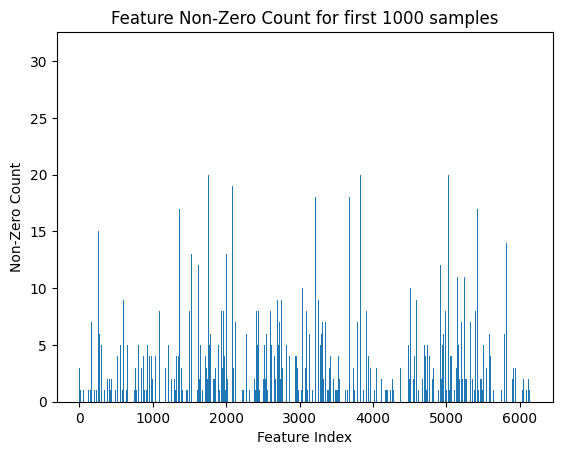

In [63]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

feature_non_zero_count = defaultdict(int)
num_samples = min(1000, len(loaded_dataset.embeddings))

for sample_idx in range(num_samples):
    feature_activations = model.forward(loaded_dataset.embeddings[sample_idx])[1]
    for idx, activation in enumerate(feature_activations):
        if activation != 0:
            feature_non_zero_count[idx] += 1

# Plotting the histogram
plt.bar(feature_non_zero_count.keys(), feature_non_zero_count.values())
plt.xlabel('Feature Index')
plt.ylabel('Non-Zero Count')
plt.title(f'Feature Non-Zero Count for first {num_samples} samples')
plt.show()

In [64]:
print(len(feature_non_zero_count.keys()))

3810


In [28]:
torch.norm(model.decoder.weight, dim=0).shape

torch.Size([6144])